# Missing Detections (False Negatives) Test

This notebook demonstrates the training and testing of an ***Optimized Kalman Filter*** (OKF) on simulated data with missing detections.
It is similar to the *Neural Kalman Filter* notebook, but handles fewer models (only KF & OKF), and runs on a dataset with missing detections (using the FN agrument in get_scenario() - see below).

All in all, the same models seem to work fine with missing detections, and to yield similar results.

In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pickle as pkl
from collections import Counter
import gc

import torch
import torch.nn.functional as F

import utils
import TargetSimulator as Sim
import SensorGenerator as Rad
import Trackers
import NeuralTrackers as NT
import TrackingLab as TLAB
import PredictionLab as PLAB

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

# Generate data

In [3]:
ID = 30

### Set configuration

In [6]:
def get_scenario(max_acc=0, n_episodes=1000, n_targets=1, n_turns=3, p_vertical=0.3, seed_base=0,
                 old_mode=True, noise=1, far=0, FN=0, title=None, train=False):
    if title is None:
        title = 'train' if train else 'test'
    seeds = seed_base + np.arange(n_episodes)
    
    return dict(
        targets = dict(
            n_episodes = n_episodes,
            dt = 1,
            old_mode = old_mode,
            acc = max_acc,
            n_targets_args = dict(n1=n_targets-3, n2=n_targets+4) if n_targets>3 else n_targets,
            init_args=dict(t0=10, dt=3, X0=(0,0,0), dx=(4e3,4e3,4e2), V0=(50,0,90), dV=(15,10000,6),
                           unif_x=True, unif_v=False), # dx=(2e3,2e3,1e2)
            n_turns_args = dict(n1=n_turns-1, n2=n_turns+2) if n_turns>1 else n_turns,
            line_args = dict(p_acc=0.5, t_mean=12, t_sigma=3, t_mean_acc=6, t_sigma_acc=2, vmax0=150),
            turn_args = dict(p_vertical=p_vertical, p_left=0.5, a_mean=45, a_sigma=270, vertical_fac=0.1),
            seeds = seeds,
            title = title,
        ),
        radar = dict(
            noise_factor = noise,
            FAR = far, # TODO FAR & missing detections
            FN = FN,
        )
    )

In [7]:
title = f'FN{ID:02d}'
p_vertical = 0.12
a_test = (24,48,96) # (24,48,96)
a_train = (48,)
test_episodes = 100 # 100
train_episodes = 4000 # 4000
n_turns = 3
noise = 1
FN = 0.05
scenarios  = [get_scenario(a_train, n_episodes=train_episodes, n_targets=1, n_turns=n_turns,
                           p_vertical=p_vertical, noise=noise, seed_base=0, train=True, FN=FN)]
scenarios += [get_scenario(a_test, n_episodes=test_episodes, n_targets=20, n_turns=n_turns,
                           p_vertical=p_vertical, noise=noise, seed_base=train_episodes, FN=FN)]
scenarios  = {sc['targets']['title']:sc for sc in scenarios}

scenarios.keys()

dict_keys(['train', 'test'])

### Generate

['train', 'test']
Generating scenario train... done.	(77 [s])
Generating scenario test... done.	(29 [s])
4000 4000 (38, 4) (38, 6) 19.0 240.0 Counter({'24<acc<48': 4000})
CPU times: user 2min 4s, sys: 5.24 s, total: 2min 9s
Wall time: 2min 10s


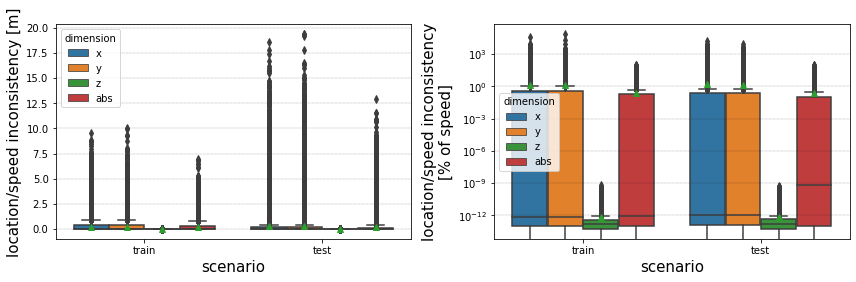

In [8]:
%%time
GENERATE = True
if GENERATE:
    # Generate data
    E = PLAB.create_experiment(scenarios=scenarios, title=title, load=False)
    E.meta_episodes.loc[E.meta_episodes.seed>=(train_episodes), 'group'] = 1
    E.meta_targets.loc[E.meta_targets.seed_ep>=(train_episodes), 'group'] = 1
    E.save_data()
    X, Y, scenarios_train = PLAB.get_group_data(E, 0)
    X2, Y2, scenarios_test = PLAB.get_group_data(E, 1)
    PLAB.save_data(X, Y, scenarios_train, fname=f'train{ID:02d}')
    PLAB.save_data(X2, Y2, scenarios_test, fname=f'test{ID:02d}')
    print(len(X), len(Y), X[0].shape, Y[0].shape, np.min(E.meta_targets['T']), np.max(E.meta_targets['T']), Counter(scenarios_train))

else:
    # just load
    E = PLAB.create_experiment(title=title, load=True)
    X, Y, scenarios_train = PLAB.get_group_data(E, 0)
    X2, Y2, scenarios_test = PLAB.get_group_data(E, 1)
    print(len(X), len(Y), X[0].shape, Y[0].shape, np.min(E.meta_targets['T']), np.max(E.meta_targets['T']), Counter(scenarios_train))

dd = E.targets_consistency_test()

### Load

In [8]:
X,Y,scenarios_train = PLAB.load_data(fname=f'train{ID:02d}')
X2,Y2,scenarios_test = PLAB.load_data(fname=f'test{ID:02d}')

#### Sample target

In [9]:
story, info = E.get_target_story()
print(info)
story

{'max_acc': 96, 'time': 36.0}


,phase,mode,time,acc,direct,angle
0,0,straight,6,75.042747,forward,0.000000
1,1,turn,4,16.094150,down,-20.581769
2,2,straight,6,59.927732,forward,0.000000
3,3,turn,8,49.299850,left,-136.521071
4,4,straight,6,80.937744,forward,0.000000
5,5,turn,3,85.172373,left,-90.698091
6,6,straight,4,83.739090,forward,0.000000


#### Trajectories lengths

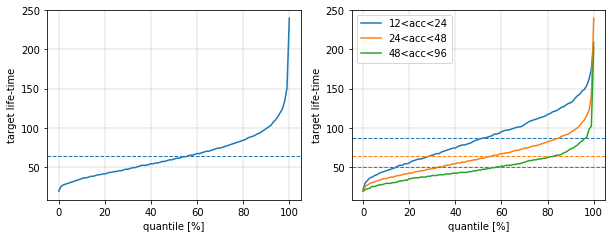

In [10]:
axs = utils.Axes(2)

utils.plot_quantiles(E.meta_targets['T'], plot_mean=True, ax=axs[0])
axs[0].set_xlabel('quantile [%]')
axs[0].set_ylabel('target life-time');

for cls in np.unique(E.meta_targets.target_class):
    utils.plot_quantiles(E.meta_targets[E.meta_targets.target_class==cls]['T'], plot_mean=True, label=cls, ax=axs[1])
axs[1].legend()
axs[1].set_xlabel('quantile [%]')
axs[1].set_ylabel('target life-time');

Text(0, 0.5, 'total time steps in data')

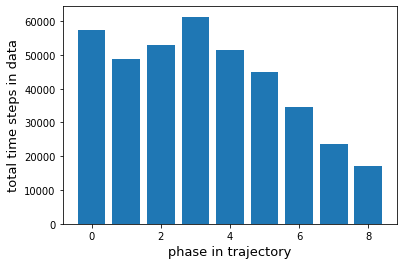

In [11]:
tmp = Counter(pd.concat([tar for sc in E.scenarios for ep in E.targets[sc] for tar in ep]).phase)
plt.bar(tmp.keys(), tmp.values())
plt.xlabel('phase in trajectory', fontsize=13)
plt.ylabel('total time steps in data', fontsize=13)

#### Sample targets

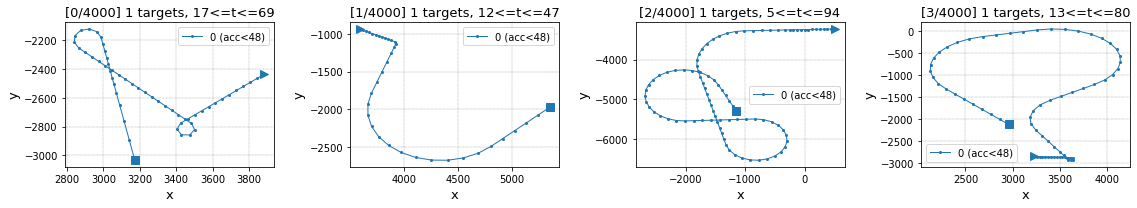

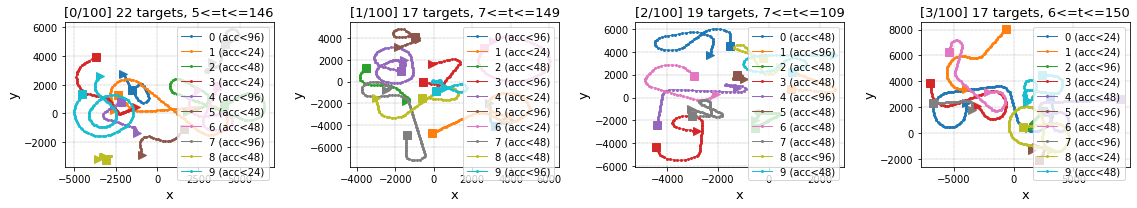

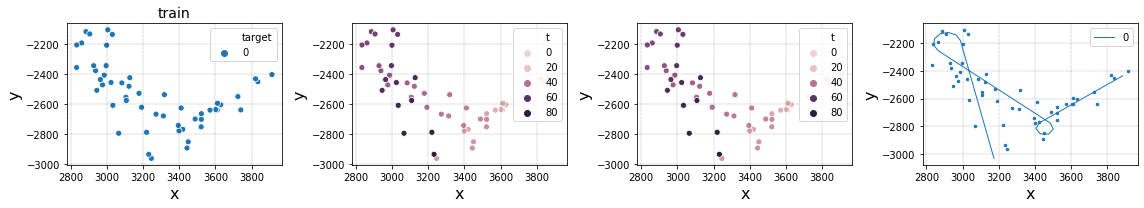

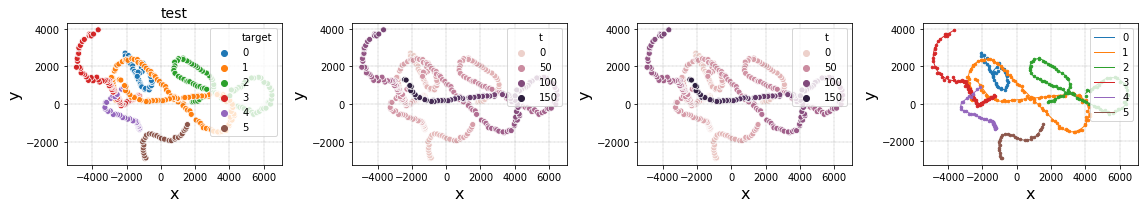

In [12]:
E.show_episodes(episodes_per_scenario=4, max_targets=10)
E.show_detections()

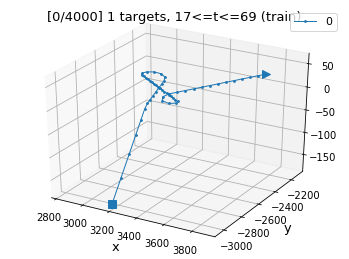

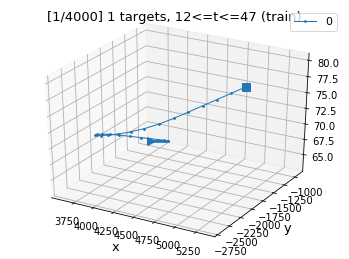

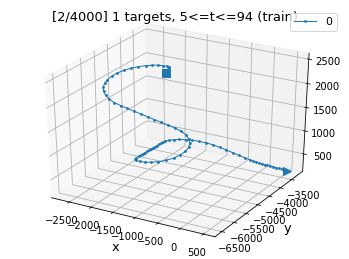

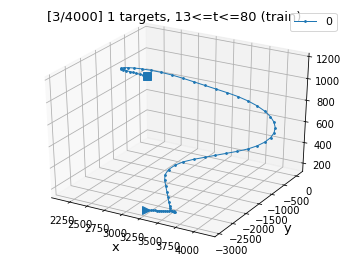

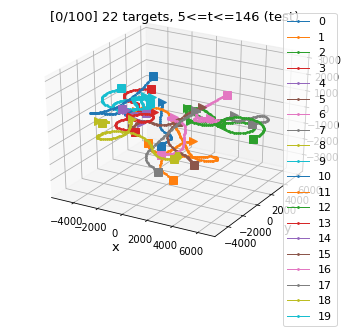

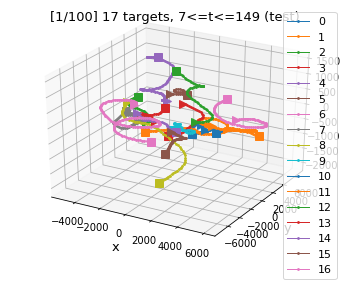

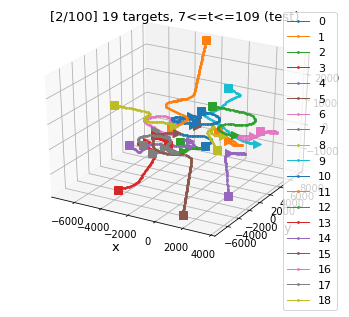

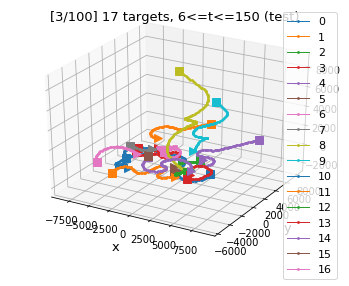

In [13]:
for sc in E.scenarios:
    Sim.show_episodes_3D(E.targets[sc], E.target_args[sc], max_episodes=4, max_targets=20, tit=sc)

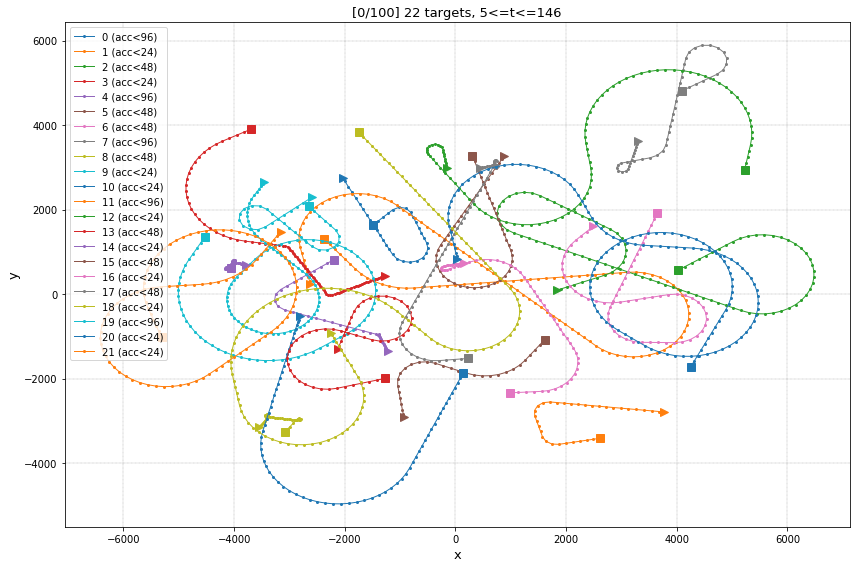

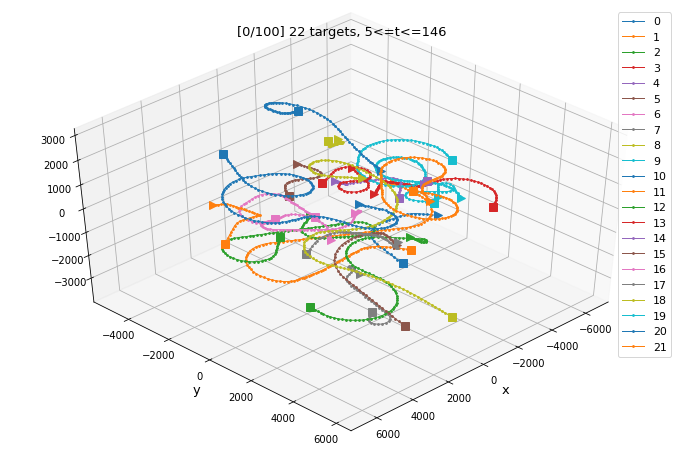

In [14]:
E.show_episodes(scenarios=['test'], episodes_per_scenario=1, max_targets=24, axs=utils.Axes(1,1,axsize=(12,8)))
axs = Sim.show_episodes_3D(E.targets['test'], E.target_args['test'], max_episodes=1, max_targets=24, figsize=(12,8))
axs[0].view_init(45, 45)

# Train models

In [18]:
models_args = [
    dict(load=False, title='KF', no_acc=True),
    dict(load=False, title='KF_p', no_acc=True, polar_R=True),
    dict(load=False, title='OKF', no_acc=True, const_R=False, const_Q=False),
    dict(load=False, title='OKF_p', no_acc=True, const_R=False, const_Q=False, polar_R=True),
]

gc.collect()

124356

Waiting for trainings...
Waiting for processes...
Done.	(2724 [s])
Best validation losses:
	KF: inf (KF_s02), inf (KF_s01), inf (KF_s00)
	KF_p: inf (KF_p_s00), inf (KF_p_s01), inf (KF_p_s02)
	OKF: 117 (OKF_s01), 117 (OKF_s00), 117 (OKF_s02)
	OKF_p: 114 (OKF_p_s00), 114 (OKF_p_s02), 114 (OKF_p_s01)


/home/ido/code/RadarSim/PredictionLab.py:1071: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


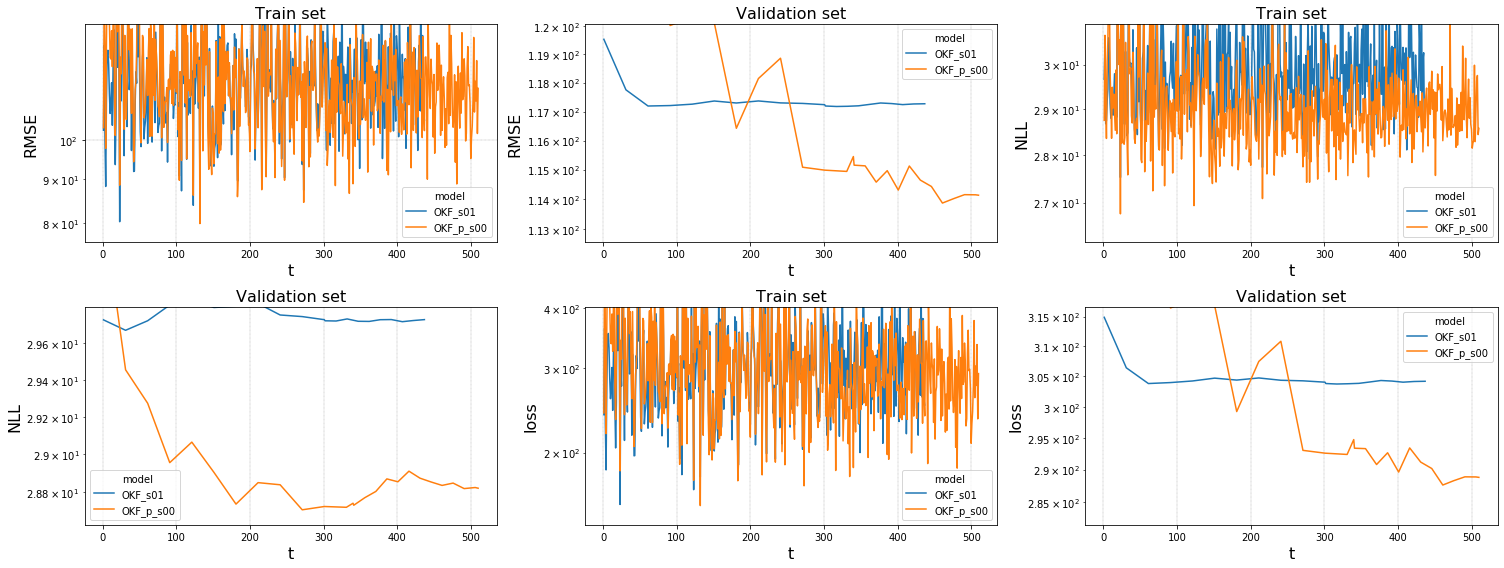

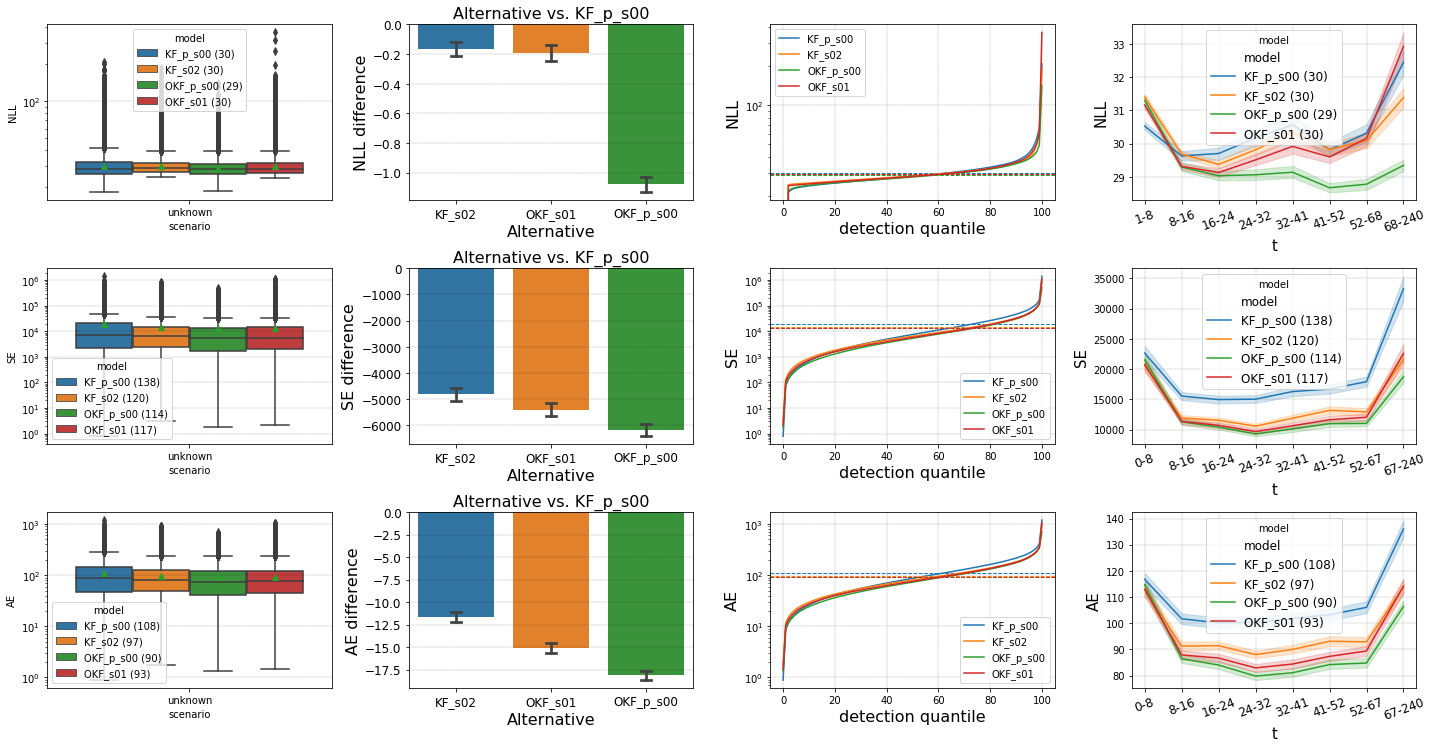

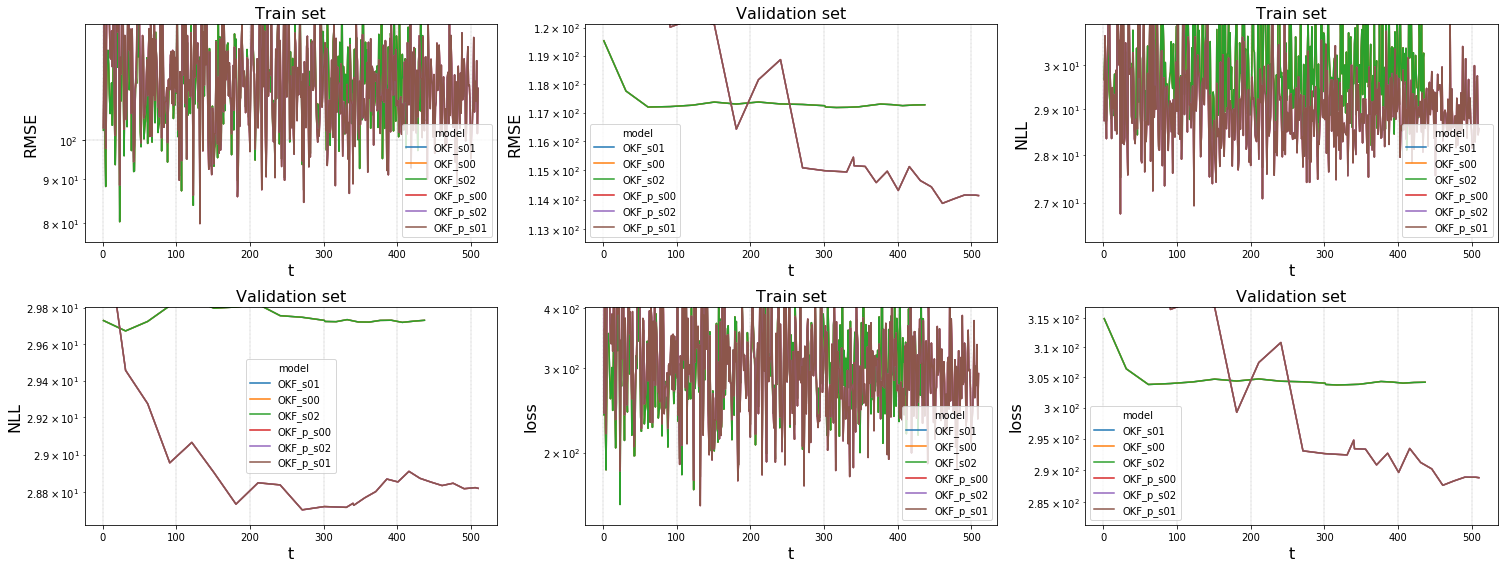

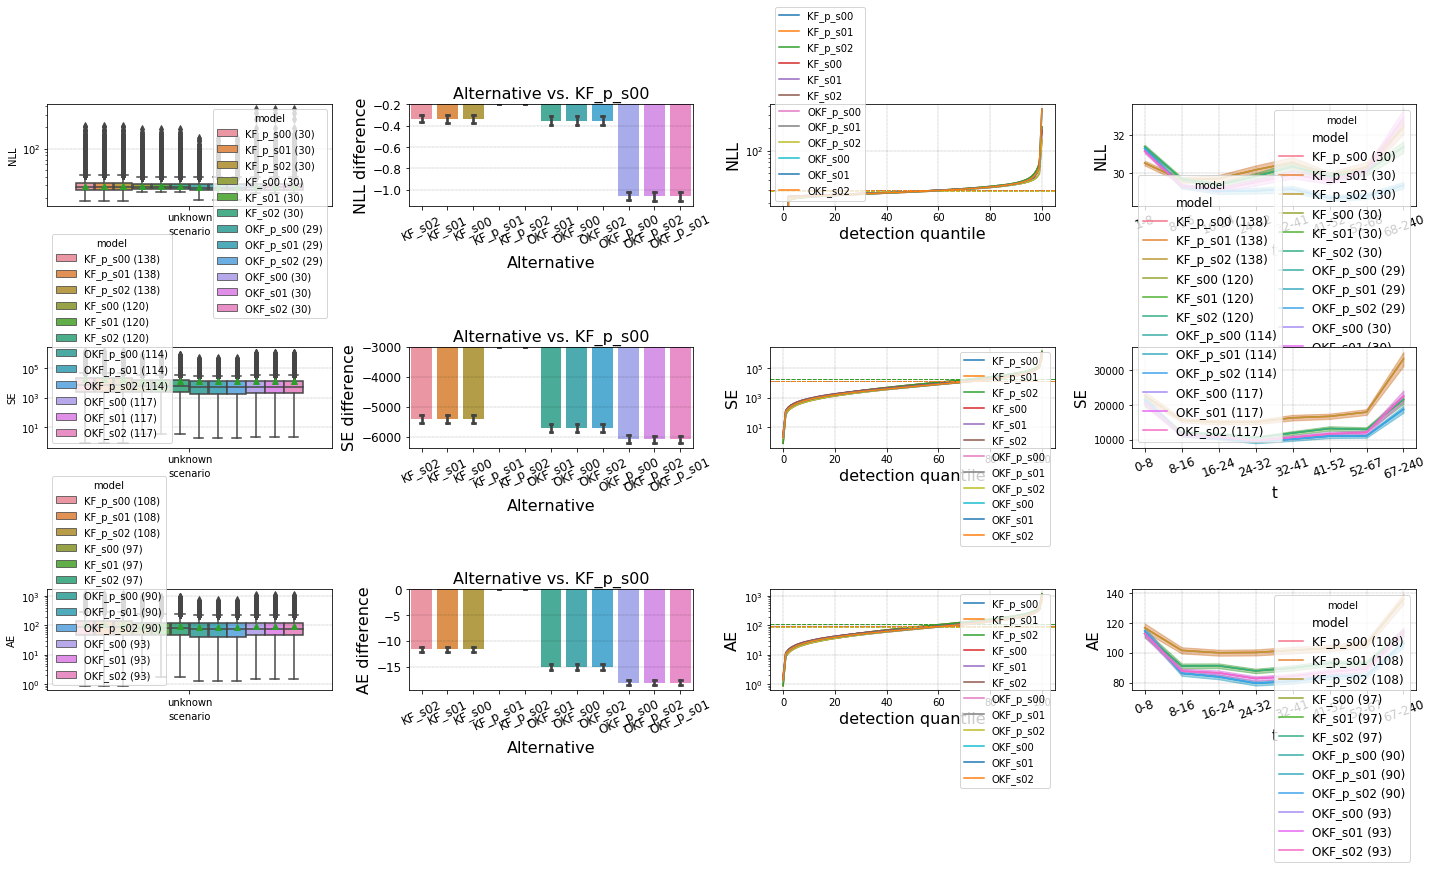

In [23]:
seeds = 3 # train each variant multiple times with different initializations (seeds), and choose the best one according to the validation data

# train
models, train_res, valid_res, ddt, ddv, losses = \
    PLAB.train_models(models_args, X, Y, seeds=seeds, save_res=f'data{ID:02d}', model_fname_prefix=f'data{ID:02d}', n_epochs=1, batch_size=10,
                      tune_phase=True, batch_fac=2, lr_fac=0.5, lr=1e-2, lr_decay=0.5, lr_decay_freq=150, verbose=2)

# show results of chosen models
PLAB.train_summary(train_res, ylim_quant=90);
PLAB.test_analysis(valid_res);

# show results of all models
if seeds > 1:
    PLAB.train_summary(ddt, ylim_quant=90);
    PLAB.test_analysis(ddv);

# Test models

4 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(51 [s])


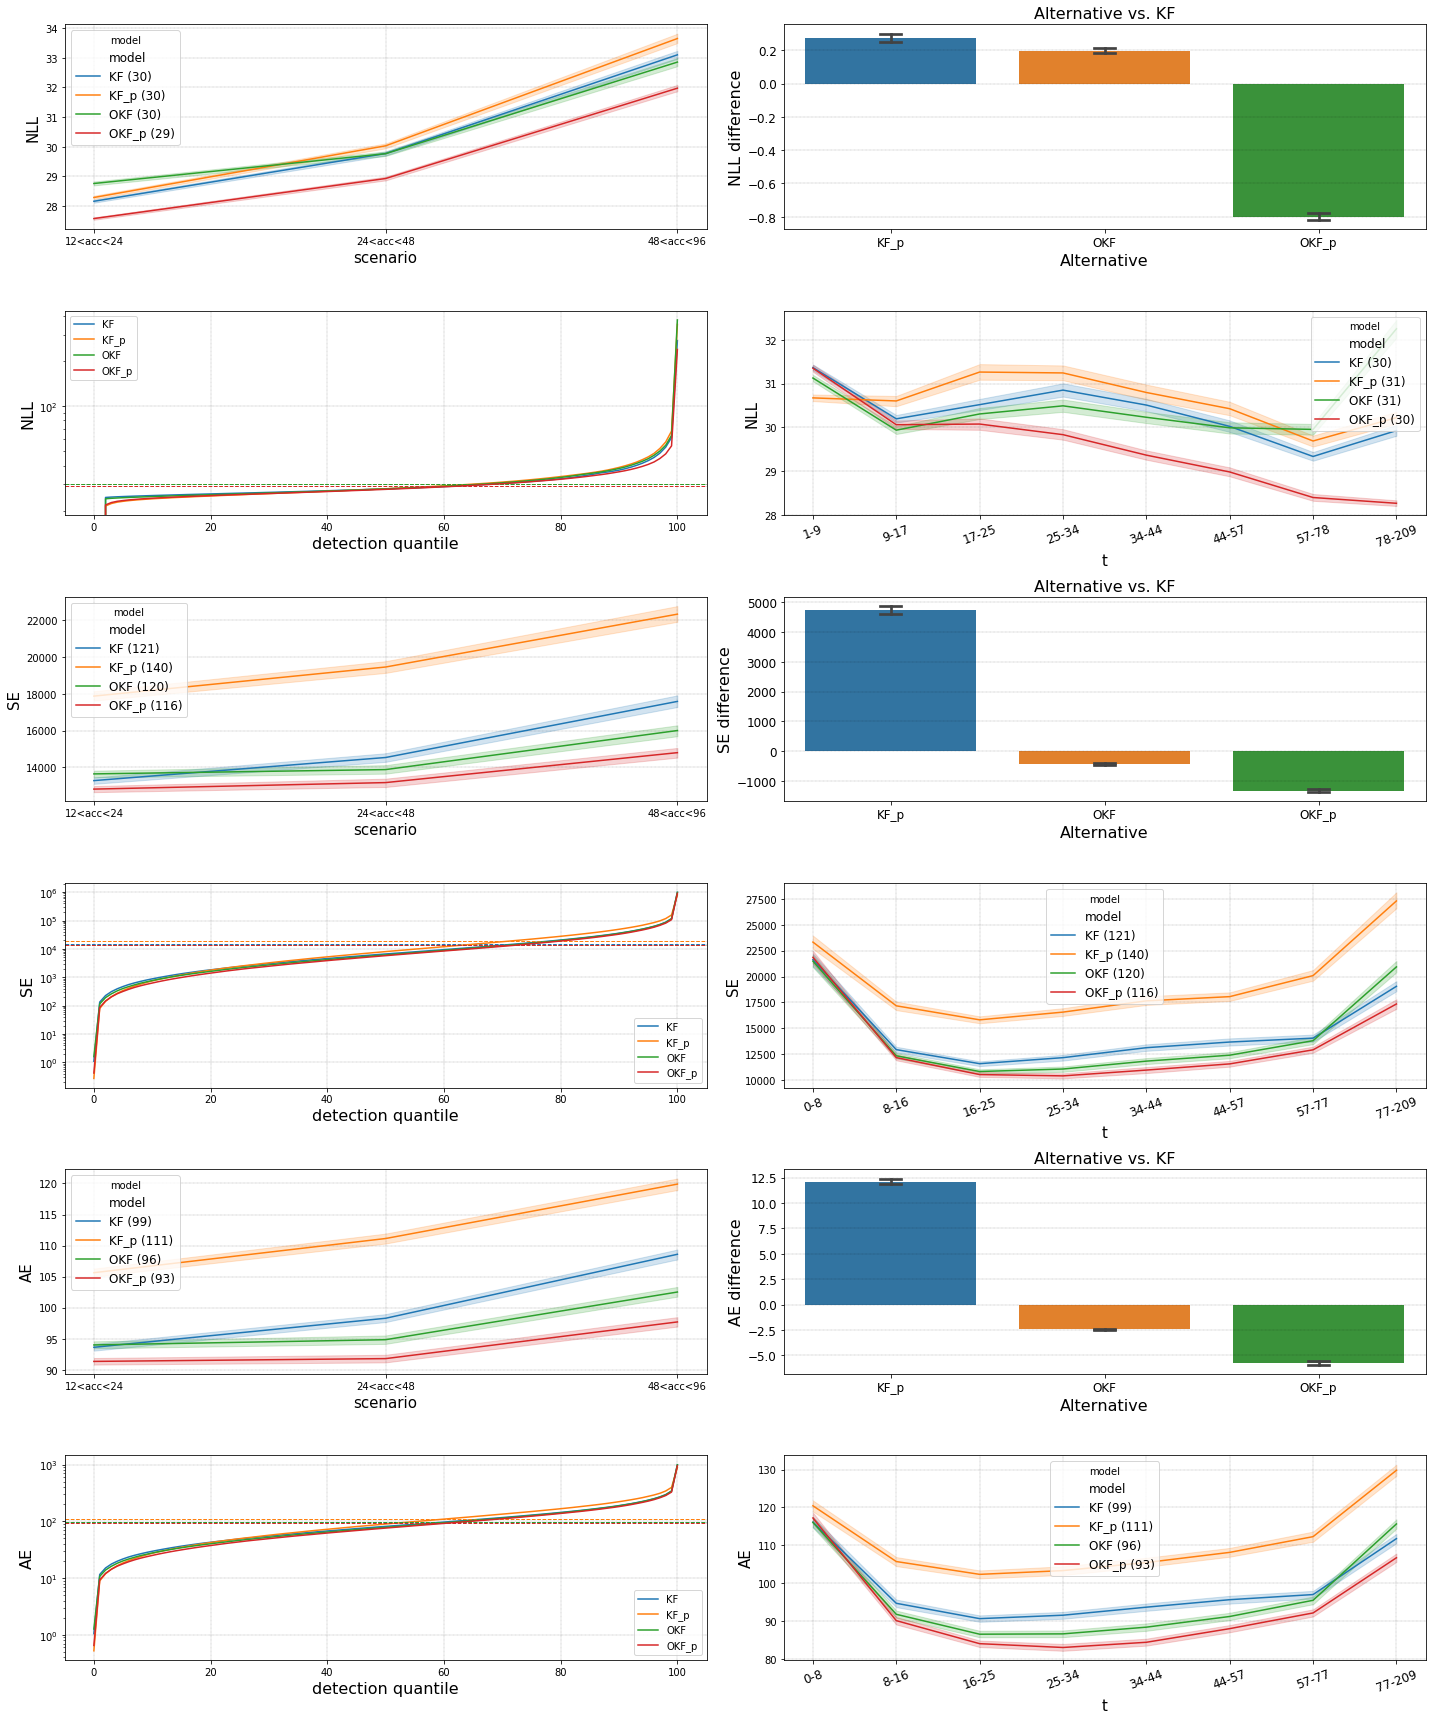

In [24]:
res = PLAB.test_models(models, X2, Y2, scenarios_test)
axs = PLAB.test_analysis(res, axargs=dict(W=2, axsize=(10,4)))